In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bornabarazandeh","key":"c3822d193b48775a56594b07f3149e6d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d splcher/animefacedataset


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 99% 392M/395M [00:18<00:00, 30.8MB/s]
100% 395M/395M [00:18<00:00, 22.6MB/s]


In [6]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.34G/2.34G [01:43<00:00, 29.7MB/s]
100% 2.34G/2.34G [01:43<00:00, 24.4MB/s]


In [7]:
!unzip -q animefacedataset.zip


In [8]:
!unzip -q cartoon-faces-googles-cartoon-set.zip

In [9]:
dataset_anime_path = "/content/images"

In [10]:
dataset_cartoon_path = "/content/cartoonset100k_jpg"

#Anime Reading:

In [8]:
import tensorflow as tf

image_files = [os.path.join(dataset_anime_path, f) for f in os.listdir(dataset_anime_path) if os.path.isfile(os.path.join(dataset_anime_path, f))]

dataset = tf.data.Dataset.from_tensor_slices(image_files)

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

dataset = dataset.map(load_and_preprocess_image)

dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

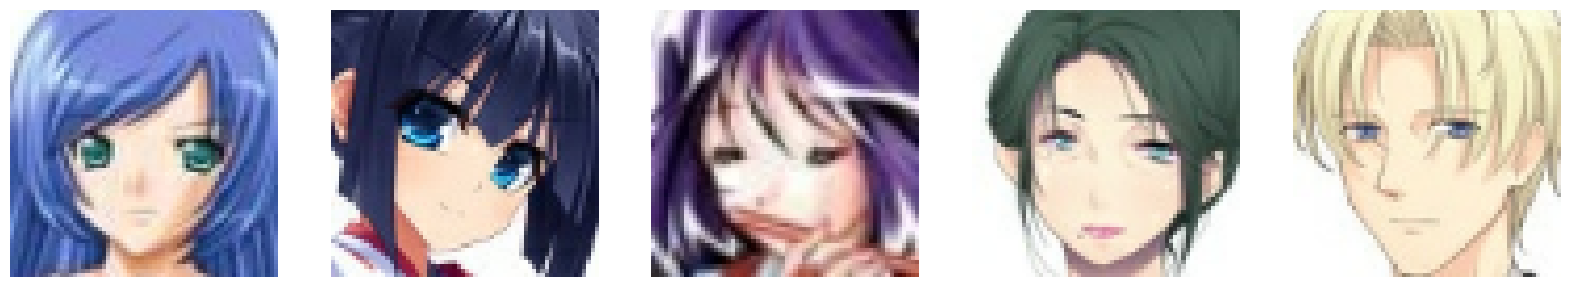

In [9]:
for images in dataset.take(1):
    images_np = images.numpy()

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_np[i])
    plt.axis('off')
plt.show()

#Cartoon Reading:

In [13]:
all_folders = [str(i) for i in range(10)]
selected_folders = random.sample(all_folders, 5)
print(f"Selected folders: {selected_folders}")

Selected folders: ['5', '2', '6', '0', '3']


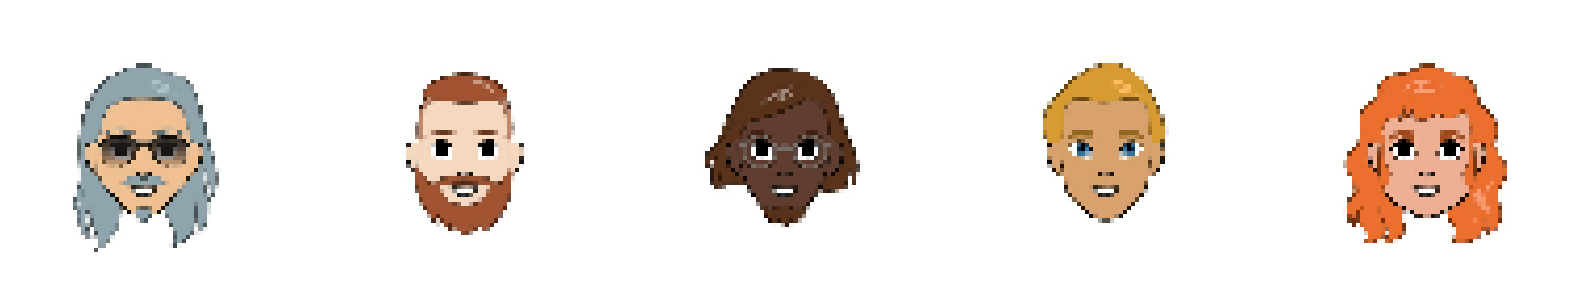

In [14]:
image_files = []
for folder in selected_folders:
    folder_path = os.path.join(dataset_cartoon_path, folder)
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            image_files.append(os.path.join(folder_path, file))

cartoon_dataset = tf.data.Dataset.from_tensor_slices(image_files)

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

cartoon_dataset = cartoon_dataset.map(load_and_preprocess_image)

cartoon_dataset = cartoon_dataset.batch(32)

for images in cartoon_dataset.take(1):
    images_np = images.numpy()

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_np[i])
    plt.axis('off')
plt.show()

#VAE Implementation:

##Encoder and Decoder:

In [10]:
from tensorflow.keras import layers, models
import tensorflow as tf

latent_dim = 32


# Enhanced Encoder
def build_encoder():
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)  # Increased to 128 neurons
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Enhanced Decoder
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 256, activation='relu')(latent_inputs)  # Increased dimensions
    x = layers.Reshape((16, 16, 256))(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

##VAE Module:

In [11]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstructed = self(data)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstructed))
            kl_loss = sum(self.losses)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "total_loss": total_loss,
        }

    def test_step(self, data):
        reconstructed = self(data)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstructed))
        kl_loss = sum(self.losses)
        total_loss = reconstruction_loss + kl_loss
        return {
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "total_loss": total_loss,
        }
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstructed))
        kl_loss = sum(self.losses)
        total_loss = reconstruction_loss + kl_loss
        return {
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "total_loss": total_loss,
        }


In [12]:
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Loss history callback
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'reconstruction_loss': [], 'kl_loss': [], 'total_loss': []}

    def on_epoch_end(self, epoch, logs={}):
        self.history['reconstruction_loss'].append(logs.get('reconstruction_loss'))
        self.history['kl_loss'].append(logs.get('kl_loss'))
        self.history['total_loss'].append(logs.get('total_loss'))

##Anime Training:

In [13]:
history = LossHistory()

vae.fit(dataset, epochs=3, callbacks=[history])

Epoch 1/3
1987/1987 [==============================] - 152s 70ms/step - reconstruction_loss: 0.6259 - kl_loss: 2.9043e-06 - total_loss: 0.6259
Epoch 2/3
1987/1987 [==============================] - 135s 68ms/step - reconstruction_loss: 0.6241 - kl_loss: 3.7128e-07 - total_loss: 0.6241
Epoch 3/3
1987/1987 [==============================] - 135s 68ms/step - reconstruction_loss: 0.6239 - kl_loss: 3.5364e-07 - total_loss: 0.6239


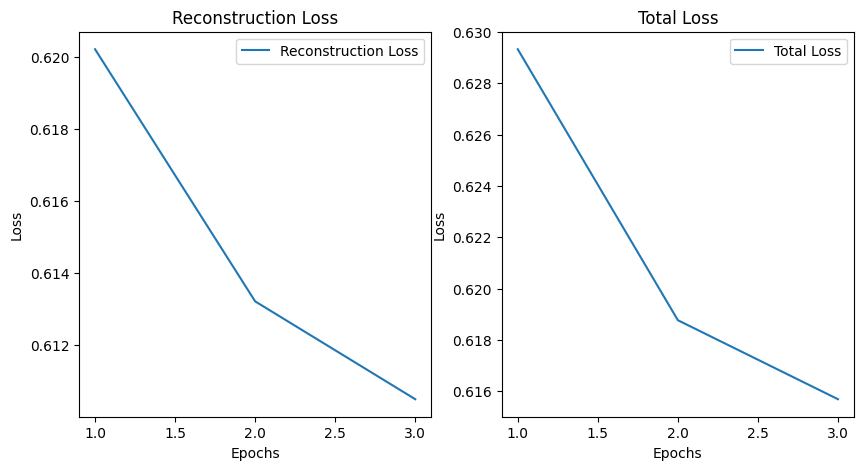

In [20]:
plt.figure(figsize=(10, 5))

reconstruction_loss = history.history['reconstruction_loss'][::-1]
total_loss = history.history['total_loss'][::-1]
epochs = range(1, len(reconstruction_loss) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, total_loss, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

plt.show()


1/1 [==============================] - 1s 1s/step


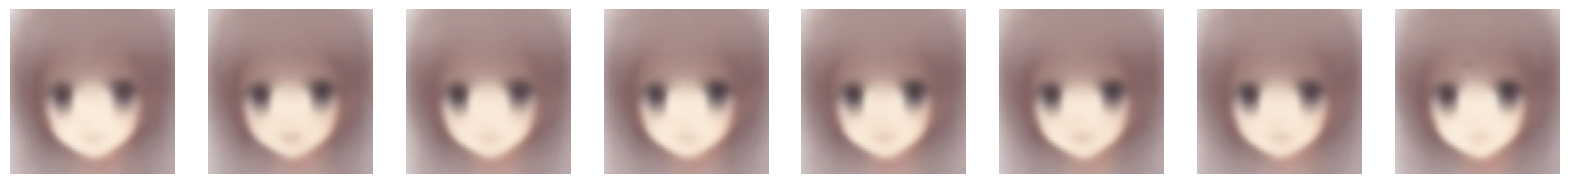

In [14]:
import numpy as np

num_samples = 8
random_noise = np.random.normal(size=(num_samples, latent_dim))

generated_images = decoder.predict(random_noise)

def plot_generated_images(images):
    plt.figure(figsize=(20, 4))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

plot_generated_images(generated_images)

##Training Cartoon:

In [23]:
encoder2 = build_encoder()
decoder2 = build_decoder()
vae2 = VAE(encoder2, decoder2)

vae2.compile(optimizer='adam')

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'reconstruction_loss': [], 'kl_loss': [], 'total_loss': []}

    def on_epoch_end(self, epoch, logs={}):
        self.history['reconstruction_loss'].append(logs.get('reconstruction_loss'))
        self.history['kl_loss'].append(logs.get('kl_loss'))
        self.history['total_loss'].append(logs.get('total_loss'))

In [24]:
history2 = LossHistory()

vae2.fit(cartoon_dataset, epochs=3, callbacks=[history2])

Epoch 1/3
1563/1563 [==============================] - 117s 70ms/step - reconstruction_loss: 0.2092 - kl_loss: 0.0017 - total_loss: 0.2109
Epoch 2/3
1563/1563 [==============================] - 106s 68ms/step - reconstruction_loss: 0.2021 - kl_loss: 0.0018 - total_loss: 0.2040
Epoch 3/3
1563/1563 [==============================] - 106s 68ms/step - reconstruction_loss: 0.2018 - kl_loss: 0.0016 - total_loss: 0.2034


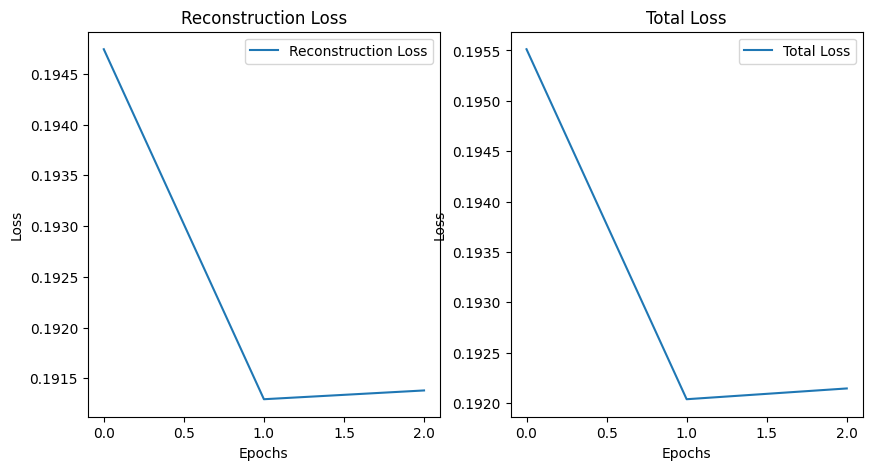

In [25]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['reconstruction_loss'], label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['total_loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 235ms/step


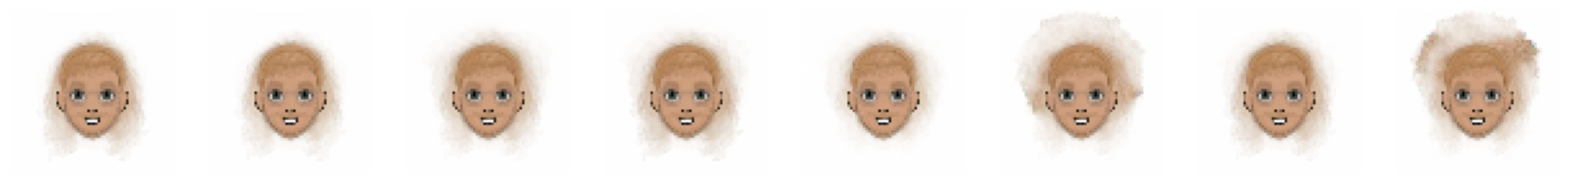

In [26]:
num_samples = 8
random_noise = np.random.normal(size=(num_samples, latent_dim))

generated_images = decoder2.predict(random_noise)
def plot_generated_images(images):
    plt.figure(figsize=(20, 4))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

plot_generated_images(generated_images)

#1-3) One Model Two Datasets:

##Reading Half of the Images:

In [12]:
import tensorflow as tf

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

anime_files = tf.io.gfile.glob(os.path.join(dataset_anime_path, "*.jpg"))
half_anime_files = anime_files[:len(anime_files)//2]
anime_labels = [0] * len(half_anime_files)

all_folders = [str(i) for i in range(10)]
selected_folders = random.sample(all_folders, 5)
print(f"Selected folders: {selected_folders}")

cartoon_files = []
cartoon_labels = []
for folder in selected_folders:
    folder_path = os.path.join(dataset_cartoon_path, folder)
    files_in_folder = tf.io.gfile.glob(os.path.join(folder_path, "*.jpg"))
    half_files_in_folder = files_in_folder[:len(files_in_folder)//2]
    cartoon_files.extend(half_files_in_folder)
    cartoon_labels.extend([1] * len(half_files_in_folder))

image_paths = half_anime_files + cartoon_files
labels = anime_labels + cartoon_labels

def create_dataset(image_paths, labels, target_size=(64, 64), batch_size=32, num_classes=2):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))


    def parse_function(path, label):
        image, label = load_and_preprocess_image(path, label)
        label = tf.one_hot(label, num_classes)
        return image, label


    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


    dataset = dataset.map(lambda img, lbl: ((img, lbl), img), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset

dataset = create_dataset(image_paths, labels)

#for data in dataset.take(1):
 #   ((images, labels), images_repeated) = data
  #  print(f'Images batch shape: {images.shape}')
   # print(f'Labels batch shape: {labels.shape}')
    #print(f'Example label: {labels[0]}')

Selected folders: ['3', '1', '9', '8', '0']


##Encoder and Sampling:

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers

class Sampling(layers.Layer):
    def call(self, inputs):

        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return mean + tf.exp(0.5 * log_var) * epsilon


def build_encoder(input_shape, latent_dim, num_classes):
    encoder_inputs = tf.keras.Input(shape=input_shape)
    label_inputs = tf.keras.Input(shape=(num_classes,))
    tiled_labels = layers.Reshape((1, 1, num_classes))(label_inputs)
    tiled_labels = tf.tile(tiled_labels, [1, input_shape[0], input_shape[1], 1])
    concatenated_inputs = layers.Concatenate()([encoder_inputs, tiled_labels])

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(concatenated_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model([encoder_inputs, label_inputs], [z_mean, z_log_var, z], name="encoder")
    return encoder


##Decoder:

In [14]:
def build_decoder(latent_dim, input_shape, num_classes):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    label_inputs = tf.keras.Input(shape=(num_classes,))
    concatenated_inputs = layers.Concatenate()([latent_inputs, label_inputs])

    x = layers.Dense(128, activation="relu")(concatenated_inputs)
    x = layers.Dense(input_shape[0] // 4 * input_shape[1] // 4 * 64, activation="relu")(x)
    x = layers.Reshape((input_shape[0] // 4, input_shape[1] // 4, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = tf.keras.Model([latent_inputs, label_inputs], decoder_outputs, name="decoder")
    return decoder

##Model:

In [15]:
def build_cvae(encoder, decoder, input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    labels = tf.keras.Input(shape=(num_classes,))
    z_mean, z_log_var, z = encoder([inputs, labels])
    reconstructed = decoder([z, labels])

    cvae = tf.keras.Model([inputs, labels], reconstructed, name="cvae")

    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.mean_squared_error(inputs, reconstructed)
    )
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

    cvae.add_loss(reconstruction_loss + kl_loss)
    cvae.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation="mean")
    cvae.add_metric(kl_loss, name="kl_loss", aggregation="mean")

    return cvae

def get_cvae(input_shape, latent_dim, num_classes, optimizer):

    encoder = build_encoder(input_shape, latent_dim, num_classes)
    decoder = build_decoder(latent_dim, input_shape, num_classes)
    cvae = build_cvae(encoder, decoder, input_shape, num_classes)

    cvae.compile(optimizer=optimizer)

    return encoder, decoder, cvae

##Loss:

In [17]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.reconstruction_losses = []
        self.kl_losses = []
        self.total_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.reconstruction_losses.append(logs.get('reconstruction_loss'))
        self.kl_losses.append(logs.get('kl_loss'))
        self.total_losses.append(logs.get('loss'))

##Train:

In [18]:
input_shape = (64, 64, 1)
latent_dim = 100
num_classes = 2
batch_size = 32
num_epochs = 3
optimizer = optimizers.Adam()

encoder, decoder, cvae = get_cvae(input_shape, latent_dim, num_classes, optimizer)

loss_history = LossHistory()

cvae.fit(dataset, epochs=num_epochs, callbacks=[loss_history])

print("Reconstruction Losses:", loss_history.reconstruction_losses)
print("KL Divergence Losses:", loss_history.kl_losses)
print("Total Losses:", loss_history.total_losses)

Epoch 1/3
1775/1775 [==============================] - 50s 11ms/step - loss: 89.5710 - reconstruction_loss: 87.5828 - kl_loss: 1.9883
Epoch 2/3
1775/1775 [==============================] - 19s 11ms/step - loss: 61.1399 - reconstruction_loss: 59.0173 - kl_loss: 2.1226
Epoch 3/3
1775/1775 [==============================] - 20s 11ms/step - loss: 57.0812 - reconstruction_loss: 55.0027 - kl_loss: 2.0785
Reconstruction Losses: [87.58277130126953, 59.017311096191406, 55.00272750854492]
KL Divergence Losses: [1.9882744550704956, 2.1225900650024414, 2.07850980758667]
Total Losses: [89.57096862792969, 61.13993835449219, 57.081214904785156]


##Generating Data:

1/1 [==============================] - 0s 28ms/step
Samples for Label 0:


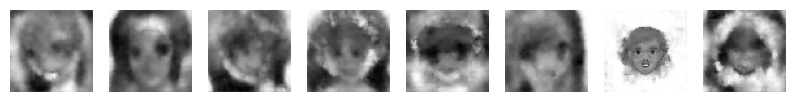

1/1 [==============================] - 0s 31ms/step
Samples for Label 1:


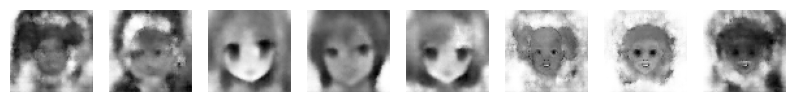

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def generate_samples(encoder, decoder, label, num_samples=8):

    latent_dim = encoder.layers[-1].output_shape[-1]

    latent_vectors = np.random.normal(size=(num_samples, latent_dim))
    labels = np.ones((num_samples, 1)) * label


    generated_images = decoder.predict([latent_vectors, labels])

    return generated_images


samples_label_0 = generate_samples(encoder, decoder, (0,0))
print("Samples for Label 0:")
plt.figure(figsize=(10, 1.2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(samples_label_0[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

 samples_label_1 = generate_samples(encoder, decoder, (0,1))
print("Samples for Label 1:")
plt.figure(figsize=(10, 1.2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(samples_label_1[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


##Encoder:

#1-4) VQ-VAE:

##Model Implementation:

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [16]:

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):

        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        quantized = tf.reshape(quantized, input_shape)


        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):

        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=(16, 16, latent_dim))
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [18]:

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(64, 64, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 16, 16, 16)        20432     
                                                                 
 vector_quantizer (VectorQu  (None, 16, 16, 16)        1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         28611     
                                                                 
Total params: 50067 (195.57 KB)
Trainable params: 50067 (195.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
import tensorflow as tf
from tensorflow import keras

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(latent_dim=self.latent_dim, num_embeddings=self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:

            reconstructions = self.vqvae(x)
            reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructions)) / self.train_variance
            total_loss = reconstruction_loss + sum(self.vqvae.losses)


        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result(),
        }


In [20]:
vqvae = get_vqvae(latent_dim=32, num_embeddings=128)
trainer = VQVAETrainer(train_variance=1.0, latent_dim=32, num_embeddings=128)

In [21]:
image_files = [os.path.join(dataset_anime_path, f) for f in os.listdir(dataset_anime_path) if os.path.isfile(os.path.join(dataset_anime_path, f))]

dataset = tf.data.Dataset.from_tensor_slices(image_files)

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

dataset = dataset.map(load_and_preprocess_image)

dataset = dataset.shuffle(buffer_size=len(image_files))
dataset = dataset.batch(32)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('reconstruction_loss'))


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

trainer.compile(optimizer=optimizer)

loss_history = LossHistory()

trainer.fit(dataset, epochs=3, callbacks=[loss_history])



#trainer.fit(dataset, epochs=3)


Epoch 1/3
1987/1987 [==============================] - 35s 10ms/step - loss: 2.2045 - reconstruction_loss: 0.0575 - vq_loss: 1.0435
Epoch 2/3
1987/1987 [==============================] - 35s 10ms/step - loss: 0.0488 - reconstruction_loss: 0.0166 - vq_loss: 0.0270
Epoch 3/3
1987/1987 [==============================] - 64s 10ms/step - loss: 0.0343 - reconstruction_loss: 0.0128 - vq_loss: 0.0211


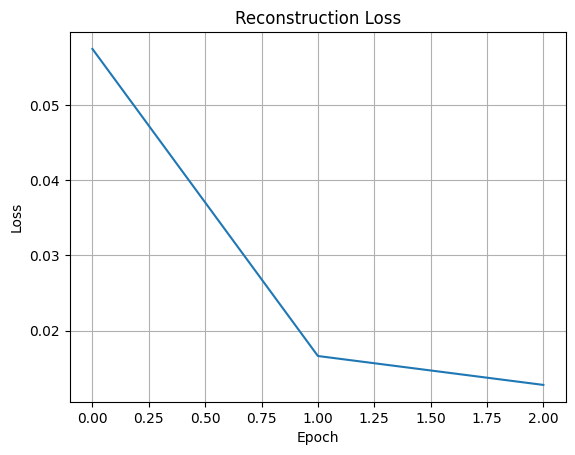

In [23]:
import matplotlib.pyplot as plt

plt.plot(loss_history.losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Plotting the results:

In [24]:
vqvae_model = trainer.vqvae

batch_size = 32
sample_images = next(iter(dataset.take(1)))[:8]

1/1 [==============================] - 1s 733ms/step


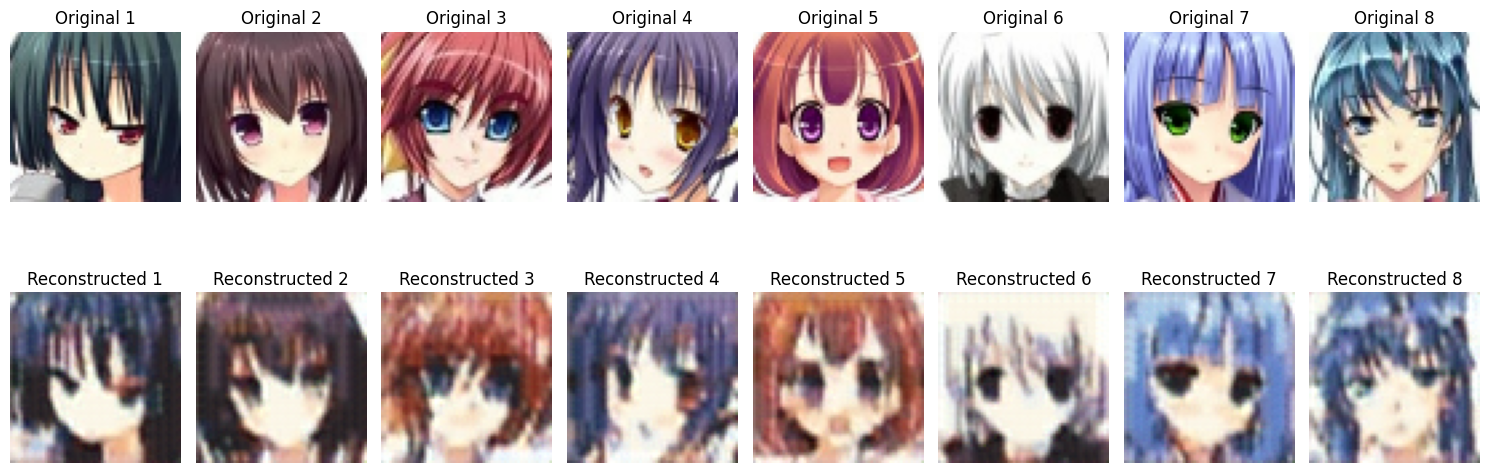

In [25]:
reconstructions = vqvae_model.predict(sample_images)

plt.figure(figsize=(15, 6))
for i in range(8):

    plt.subplot(2, 8, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f'Original {i+1}')
    plt.axis('off')


    plt.subplot(2, 8, i + 1 + 8)
    plt.imshow(reconstructions[i])
    plt.title(f'Reconstructed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 18ms/step


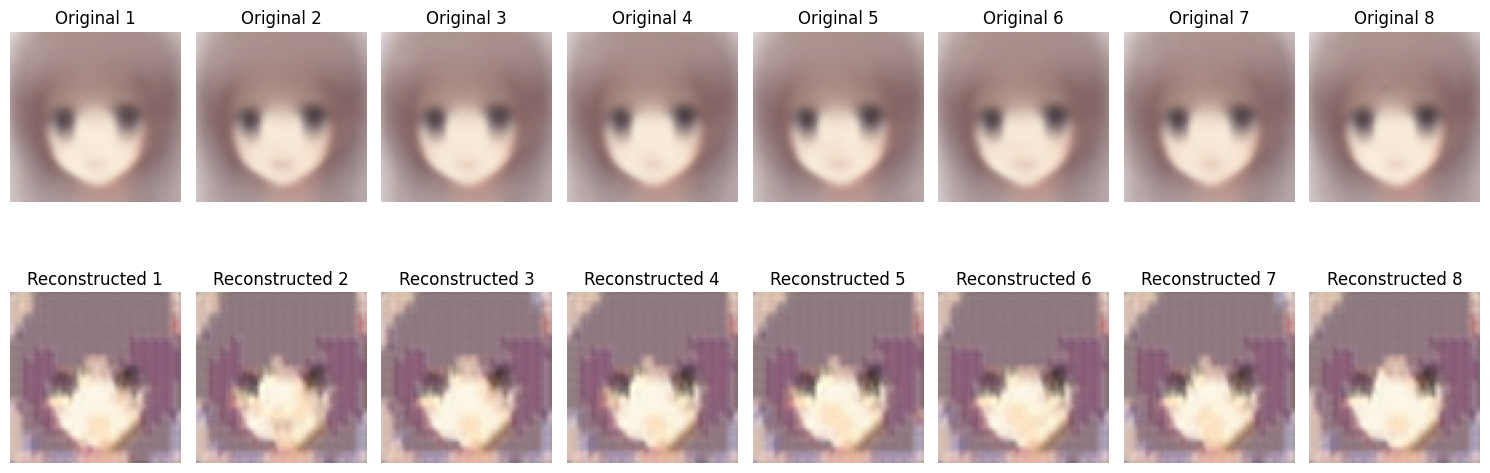

In [26]:
reconstructions2 = vqvae_model.predict(generated_images)

plt.figure(figsize=(15, 6))
for i in range(8):

    plt.subplot(2, 8, i + 1)
    plt.imshow(generated_images[i])
    plt.title(f'Original {i+1}')
    plt.axis('off')


    plt.subplot(2, 8, i + 1 + 8)
    plt.imshow(reconstructions2[i])
    plt.title(f'Reconstructed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()